# จัดกระทำข้อมูลเบื้องต้น และสำรวจข้อมูล
INPUT : 
   - movies_metadata.csv
   - keywords.csv
   - credits.csv
OUTPUT :
   - cleaned_6610401993.csv
   - cleaned_6610401993.pkl
คำอธิบาย
   - column output เพิ่มเติม
       'genres' : ระบุประเภทหนังใน list เช่น ["Adventure","Comedy"]
       'collection_name' : ระบุชื่อ series หนัง
       'collection_count' : ระบุจำนวนหนังใน series เดียวกัน
       'main_cast_gender' : ระบุเพศนักแสดงหลัก
       'main_cast_character' : ระบุชื่อตัวละครหลัก
       'main_cast_name' : ระบุชื่อตัวระครหลัก
       'movie_after' : จำนวนภาคต่อจากหนังเรื่องนี่
       'roi' : ระบุ return of investment = revenue / budget
       'keywords' : ระบุ keyword ในหนัง
       'vote_after' : ระบุ คะแนน ในภาคถัดไป
       'next_main_cast_gender_same' : ภาคต่อไปตัวละครเพศเดียวกันไหม
       'next_main_cast_actor_name_same' : ภาคต่อไปนักแสดงคนเดียวกันไหม
       'next_main_cast_same' : ภาคต่อไปตัวละครตัวเดียวกันไหม
       'vote_increase' : มีการเพิ่มของโหวดเท่าไรในภาคถึดไป = (โหวดภาคต่อไป/โหวดภาคนี้) - 1

# Clean Data

### Import Dependencies

In [846]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
from sklearn.utils import shuffle
from scipy import stats
import kagglehub
import seaborn as sns

### set randomseed to be deterministic

In [847]:
# Define seed


### set path

In [848]:
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sunmodza\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7


In [849]:
!ls C:\Users\sunmodza\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [850]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable


In [851]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# โหลดข้อมูล

## โหลดข้อมูลโดยรวมของหนัง (ส่วนใหญ่ข้อมูลที่วิเคราะห์จะอยู่ในนี้)

In [852]:
df = pd.read_csv(path+"\movies_metadata.csv")

C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\3710841025.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+"\movies_metadata.csv")


## โหลดข้อมูล keyword ของหนัง

In [853]:
df_keyword = pd.read_csv(path+"\keywords.csv")

## โหลดข้อมูล นักแสดง และผู้อยู่เบื้องหลังของหนัง

In [854]:
df_credit = pd.read_csv(path+"\credits.csv")

# สำรวจข้อมูลเบื้องต้น

## 1. DataFrame หลัก

<p>
ชุดข้อมูลนี้ประกอบด้วยข้อมูลเกี่ยวกับภาพยนตร์ทั้งหมด <b>24 คอลัมน์</b> และ <b>45,466 แถว</b> แต่ละคอลัมน์มีความหมายดังนี้:
</p>

<ul>
    <li>
        <b>adult</b>: (บูลีน) ระบุว่าภาพยนตร์เรื่องนี้มีเนื้อหาสำหรับผู้ใหญ่หรือไม่
        <ul>
            <li><code>False</code>: ไม่ใช่ภาพยนตร์สำหรับผู้ใหญ่</li>
            <li><code>True</code>: เป็นภาพยนตร์สำหรับผู้ใหญ่</li>
        </ul>
    </li>
    <li>
        <b>belongs_to_collection</b>: (พจนานุกรมซ้อนพจนานุกรม) ข้อมูลเกี่ยวกับชุดภาพยนตร์ (แฟรนไชส์) ที่ภาพยนตร์เรื่องนี้เป็นส่วนหนึ่ง หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่างสำหรับ "Toy Story":
        <pre><code>
{
  "id": 10194,
  "name": "Toy Story Collection",
  "poster_path": "/7G9915LfFDa1meEPejOOtF/YVq46h.jpg",
  "backdrop_path": "/9FBwqcdajxgiiD1IrOkNHucRTLq.jpg"
}
        </code></pre>
    </li>
    <li>
        <b>budget</b>: (จำนวนเต็ม) งบประมาณที่ใช้ในการสร้างภาพยนตร์ (ดอลลาร์สหรัฐ)
        <br>
        ตัวอย่าง: <code>30000000</code>
    </li>
    <li>
        <b>genres</b>: (รายชื่อพจนานุกรม) ประเภท (แนว) ของภาพยนตร์แต่ละประเภท โดยแต่ละประเภทจะมี ID และชื่อ
        <br>
        ตัวอย่างสำหรับ "Toy Story":
        <pre><code>
[
  {"id": 16, "name": "Animation"},
  {"id": 35, "name": "Comedy"},
  {"id": 10751, "name": "Family"}
]
        </code></pre>
    </li>
    <li>
        <b>homepage</b>: (URL) เว็บไซต์อย่างเป็นทางการของภาพยนตร์ หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่าง: <code>http://toystory.disney.com/toy-story</code>
    </li>
    <li>
        <b>id</b>: (จำนวนเต็ม) รหัสเฉพาะของภาพยนตร์ในฐานข้อมูล
    </li>
    <li>
        <b>imdb_id</b>: (สตริง) รหัสเฉพาะของภาพยนตร์ในฐานข้อมูล IMDb
        <br>
        ตัวอย่าง: <code>tt0114709</code>
    </li>
    <li>
        <b>original_language</b>: (สตริง) รหัสภาษา ISO 639-1 ของภาษาต้นฉบับ
        <br>
        ตัวอย่าง: <code>'en'</code> (ภาษาอังกฤษ)
    </li>
    <li>
        <b>original_title</b>: (สตริง) ชื่อดั้งเดิมของภาพยนตร์ (โดยทั่วไปเป็นชื่อในภาษาต้นฉบับ)
        <br>
        ตัวอย่าง: <code>"Toy Story"</code>
    </li>
    <li>
        <b>overview</b>: (สตริง) บทสรุปย่อของภาพยนตร์
    </li>
    <li>
        <b>popularity</b>: (ทศนิยม) ค่าความนิยมของภาพยนตร์
    </li>
    <li>
        <b>poster_path</b>: (สตริง) เส้นทางไปยังรูปภาพโปสเตอร์ของภาพยนตร์
    </li>
    <li>
        <b>production_companies</b>: (รายชื่อพจนานุกรม) บริษัทที่เกี่ยวข้องกับการผลิตภาพยนตร์ โดยแต่ละบริษัทจะมีชื่อและ ID
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"name": "Pixar Animation Studios", "id": 3}
]
        </code></pre>
    </li>
    <li>
        <b>production_countries</b>: (รายชื่อพจนานุกรม) ประเทศที่ผลิตภาพยนตร์ โดยแต่ละประเทศจะมีรหัส ISO 3166-1 และชื่อ
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"iso_3166_1": "US", "name": "United States of America"}
]
        </code></pre>
    </li>
    <li>
        <b>release_date</b>: (วันที่) วันที่เข้าฉายของภาพยนตร์
    </li>
    <li>
        <b>revenue</b>: (ทศนิยม) รายได้รวมของภาพยนตร์ทั่วโลก (ดอลลาร์สหรัฐ)
        <br>
        ตัวอย่าง: <code>373554033.0</code>
    </li>
    <li>
        <b>runtime</b>: (ทศนิยม) ระยะเวลาฉายของภาพยนตร์ (นาที)
        <br>
        ตัวอย่าง: <code>81.0</code>
    </li>
    <li>
        <b>spoken_languages</b>: (รายชื่อพจนานุกรม) ภาษาที่ใช้พูดในภาพยนตร์ โดยแต่ละภาษาจะมีรหัส ISO 639-1 และชื่อ
        <br>
        ตัวอย่าง:
        <pre><code>
[
  {"iso_639_1": "en", "name": "English"}
]
        </code></pre>
    </li>
    <li>
        <b>status</b>: (สตริง) สถานะปัจจุบันของภาพยนตร์ เช่น "Released", "In Production"
    </li>
    <li>
        <b>tagline</b>: (สตริง) สโลแกนของภาพยนตร์ หากไม่มี จะเป็นค่าว่าง (NaN หรือ Null)
        <br>
        ตัวอย่าง: <code>NaN</code>
    </li>
    <li>
        <b>title</b>: (สตริง) ชื่อเรื่องของภาพยนตร์ (อาจแตกต่างจาก <code>original_title</code> หากมีการแปล)
        <br>
        ตัวอย่าง: <code>"Toy Story"</code>
    </li>
    <li>
        <b>video</b>: (บูลีน) ระบุว่ามีวิดีโอตัวอย่าง (trailer) หรือไม่
        <ul>
            <li><code>False</code>: ไม่มีวิดีโอตัวอย่าง</li>
            <li><code>True</code>: มีวิดีโอตัวอย่าง</li>
        </ul>
    </li>
    <li>
        <b>vote_average</b>: (ทศนิยม) คะแนนเฉลี่ยที่ผู้ชมโหวตให้กับภาพยนตร์ (0 ถึง 10)
    </li>
    <li>
        <b>vote_count</b>: (ทศนิยม) จำนวนครั้งที่ผู้ชมโหวตให้กับภาพยนตร์
    </li>
</ul>

In [855]:
df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [856]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [857]:
df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [858]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

## Keyword DF

เก็บข้อมูล keyword ของแต่ละ Movie โดย id สามารถเชื่อมโยงกับ Main DataFrame ได้
- keywords : เก็บทุก keyword ของแต่ละ movie โดยสามารถมีหลาย keyword ได้ ภายในแต่ละ keyword มี id ของ keyword นั้น กับ name หรือชื่อ

In [859]:
df_keyword.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [860]:
df_keyword.columns

Index(['id', 'keywords'], dtype='object')

In [861]:
df_keyword.describe()

,id
count,46419.000000
mean,109769.951873
std,113045.780256
min,2.000000
25%,26810.500000
50%,61198.000000
75%,159908.500000
max,469172.000000


In [862]:
df_keyword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


## 3. Credit DataFrame

เก็บข้อมูลของนักแสดงและผู้อยู่เบื้องหลังของแต่ละ Movie โดย id สามารถเชื่อมโยงกับ Main DataFrame ได้
- cast : นักแสดงหลักประกอบด้วยหลายอันใน 1 cell แต่ละอันมีค่าดังตัวอย่างดังนี้
    {'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}
    - cast_id : id นักแสดง
    - character : ชื่อตัวละครที่แสดง
    - credit_id : id ของ entity
    - gender : เพศของนักแสดง
    - name : ชื่อของนักแสดง
    - order : เลขน้อยคือตัวละครหลัก (เริ่มจาก 0)
    - profile_path : โยงไปยังที่เก็บรูป (ไม่ได้ใช้)

In [863]:
df_credit.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [864]:
df_credit["cast"].iloc[0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

# Data Preparing & Cleaning

## Missing Data ใน DataFrame หลัก

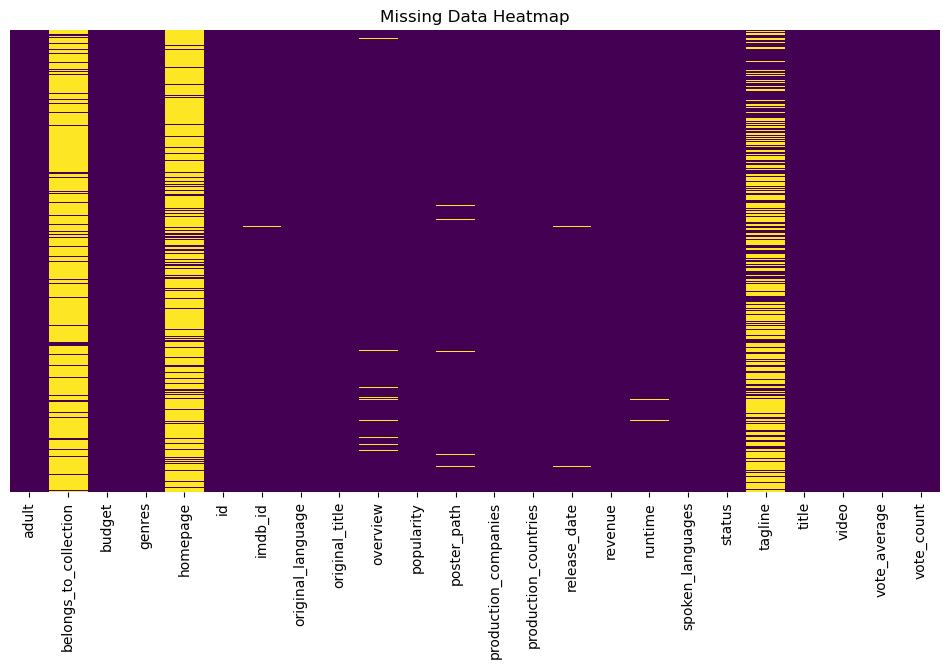

In [865]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [866]:
df.isnull().sum().rename("missing_values")

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
Name: missing_values, dtype: int64

In [867]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [868]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45466 non-null  object        
 1   belongs_to_collection  4494 non-null   object        
 2   budget                 45466 non-null  object        
 3   genres                 45466 non-null  object        
 4   homepage               7782 non-null   object        
 5   id                     45466 non-null  object        
 6   imdb_id                45449 non-null  object        
 7   original_language      45455 non-null  object        
 8   original_title         45466 non-null  object        
 9   overview               44512 non-null  object        
 10  popularity             45461 non-null  object        
 11  poster_path            45080 non-null  object        
 12  production_companies   45463 non-null  object        
 13  p

### ปรับแก้ประเภทตัวแปรเป็น numeric

In [869]:
df = df[pd.to_numeric(df['budget'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['popularity'], errors='coerce').notnull()]
df['budget'] = df['budget'].astype(float)
df['popularity'] = df['popularity'].astype(float)

### deduplication id

In [870]:
df = df.drop_duplicates(subset=['id'])

# สร้างชุดข้อมูลเพิ่มเติม หรือทำการนำ Repeating Group ออกมา

### สร้าง dataframe ที่แสดงข้อมูล collection ต่างๆที่มีใน movie
 - collection คือ movie ที่เป็น set เดียวกัน

In [871]:
collect = []
for v in df.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["belongs_to_collection"]))
        bc["movie_id"] = v["id"]
        bc.pop("id")
        bc.pop("poster_path")
        bc.pop("backdrop_path")
    except Exception as e:
        bc = {}
        continue
    collect.append(bc)

In [872]:
collect_df = pd.DataFrame(collect)

### สร้าง Feature จำนวนหนังใน Collection เดัยวกับ และจำนวนหนังก่อนเรื่องนี้ เพื่อนำไปใช้ต่อ

In [873]:
# find how many number of movie sequal that come before them
# Count how many movies are in each collection
collection_counts = collect_df['name'].value_counts().reset_index()
collection_counts.columns = ['collection_name', 'movie_count']

# Display collections with more than one movie (sequels)
sequels_df = collection_counts[collection_counts['movie_count'] > 1]
print(f"There are {len(sequels_df)} movie collections with sequels")

# For each movie, find how many movies in its collection came before it
# First, merge release dates from main dataframe
collect_with_dates = collect_df.merge(df[['id', 'release_date']], 
                                     left_on='movie_id', 
                                     right_on='id', 
                                     how='left')

# Group by collection name and count movies released before each movie
movies_before = []
for name, group in collect_with_dates.groupby('name'):
    # Convert release_date to datetime
    group['release_date'] = pd.to_datetime(group['release_date'], errors='coerce')
    # Sort by release date
    group = group.sort_values('release_date')
    
    # For each movie in the collection, count how many came before it
    for i, row in enumerate(group.itertuples()):
        movies_before.append({
            'movie_id': row.movie_id,
            'collection_name': name,
            'movies_before': i,  # Index in sorted group = number of movies before
            'release_date': row.release_date
        })

# Create dataframe with results
sequels_count_df = pd.DataFrame(movies_before)
# drop release date
sequels_count_df.drop(columns=['release_date'], inplace=True)
sequels_count_df.head(10)

# add same collection count to all movie with collection
sequels_count_df["collection_count"] = sequels_count_df.groupby("collection_name")["movie_id"].transform("count")
sequels_count_df.head(10)


There are 1305 movie collections with sequels


,movie_id,collection_name,movies_before,collection_count
0,117263,... Has Fallen Collection,0,2
1,267860,... Has Fallen Collection,1,2
2,1652,00 Schneider Filmreihe,0,1
3,19430,08/15 Collection,0,1
4,10035,100 Girls Collection,0,2
5,20648,100 Girls Collection,1,2
6,12230,101 Dalmatians (Animated) Collection,0,2
7,13654,101 Dalmatians (Animated) Collection,1,2
8,11674,101 Dalmatians (Live-Action) Collection,0,2
9,10481,101 Dalmatians (Live-Action) Collection,1,2


In [874]:
df = df.drop(columns=["belongs_to_collection"])

### สร้าง DataFrame ของประเภทหนัง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [875]:
genres_data = []
for v in df.iterrows():
    v = v[1]
    genre = eval(v["genres"])
    for item in genre:
        item["movie_id"] = v["id"]
        item.pop("id")
        genres_data.append(item)
df_genre = pd.DataFrame(genres_data)

In [876]:
df_genre.head(5)

,name,movie_id
0,Animation,862
1,Comedy,862
2,Family,862
3,Adventure,8844
4,Fantasy,8844


### สร้าง DataFrame ของ production companies ที่เกี่ยวข้องกับหนังแต่ละเรื่อง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [877]:
prod_comp = []
for v in df.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["production_companies"]))
        for item in bc:
            item["movie_id"] = v["id"]
            item.pop("id")
            prod_comp.append(item)
    except Exception as e:
        bc = {}
        continue
    #print(bc)
    #prod_comp.append(bc)

df_prod_comp = pd.DataFrame(prod_comp)

In [878]:
df_prod_comp.head(5)

,name,movie_id
0,Pixar Animation Studios,862
1,TriStar Pictures,8844
2,Teitler Film,8844
3,Interscope Communications,8844
4,Warner Bros.,15602


### แปลงรูปแบบของ df_keyword ให้ใช้งานได้โดยทำการลบ repeating group

In [879]:
kws = []
for v in df_keyword.iterrows():
    v = v[1]
    try:
        bc = eval(str(v["keywords"]))
        for item in bc:
            item["movie_id"] = v["id"]
            item.pop("id")
            kws.append(item)
    except Exception as e:
        bc = {}
        continue

df_keyword = pd.DataFrame(kws)
df_keyword["movie_id"] = df_keyword["movie_id"].astype(str)

In [880]:
df_keyword.head(5)

,name,movie_id
0,jealousy,862
1,toy,862
2,boy,862
3,friendship,862
4,friends,862


### สร้าง DataFrame ของ นักแสดงและผู้อยู่เบื่องหลัง ที่เกี่ยวข้องกับหนังแต่ละเรื่อง โดยลบ repeating group เพื่อนำไปใช้ในขั้นตอนต้อๆไป

In [881]:
# Extract the first character from each cast member
cast_first_chars = []
for row in df_credit.iterrows():
    row_data = row[1]
    try:
        cast_data = eval(str(row_data["cast"]))
        if cast_data and len(cast_data) > 0:
            # Get only the first character from the cast list
            first_character = cast_data[0]
            first_character["movie_id"] = row_data["id"]
            cast_first_chars.append(first_character)
    except Exception as e:
        continue

df_cast_first = pd.DataFrame(cast_first_chars)


In [882]:
df_cast_first = df_cast_first[["movie_id","gender","character","name"]]

In [883]:
df_cast_first["gender"] = df_cast_first["gender"].replace({1:"woman",2:"man",3:"other"})
df_cast_first = df_cast_first.rename({"name":"main_cast_name","gender":"main_cast_gender","character":"main_cast_character"},axis=1)
df_cast_first["movie_id"] = df_cast_first["movie_id"].astype(str)

In [884]:
df_cast_first.head(5)

,movie_id,main_cast_gender,main_cast_character,main_cast_name
0,862,man,Woody (voice),Tom Hanks
1,8844,man,Alan Parrish,Robin Williams
2,15602,man,Max Goldman,Walter Matthau
3,31357,woman,Savannah 'Vannah' Jackson,Whitney Houston
4,11862,man,George Banks,Steve Martin


## รวมกับชุดข้อมูลหลัก

In [885]:
df_insight = df.merge(sequels_count_df, left_on="id", right_on="movie_id", how="left")
df_insight["movies_before"] = df_insight["movies_before"].fillna(0)
df_insight["collection_count"] = df_insight["collection_count"].fillna(1)
df_insight.shape

(45430, 27)

In [886]:
# merge
df_insight = df_insight.merge(df_cast_first, how="left", right_on="movie_id", left_on="id", suffixes=('', '_drop'))
df_insight = df_insight.loc[:, ~df_insight.columns.str.endswith('_drop')]
collect_df_join = collect_df.merge(df_insight, how="left", left_on="movie_id", right_on="id", suffixes=('', '_drop'))
collect_df_join = collect_df_join.loc[:, ~collect_df_join.columns.str.endswith('_drop')]
collect_df_join = collect_df_join.rename(columns={'name': 'collection_name'})
df_insight = df_insight.merge(collect_df_join, how="left", left_on="movie_id", right_on="movie_id", suffixes=('', '_drop'))
df_insight = df_insight.loc[:, ~df_insight.columns.str.endswith('_drop')]
df_insight.shape

(45482, 30)

In [887]:
df_insight["movie_after"] = df_insight["collection_count"] - df_insight["movies_before"] - 1
df_insight["roi"] = df_insight["revenue"] / df_insight["budget"]
df_insight = df_insight.replace([np.inf, -np.inf], np.nan)
#df_insight = df_insight.dropna(subset=['roi'])
df_insight.shape

C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\1873543608.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_insight = df_insight.replace([np.inf, -np.inf], np.nan)


(45482, 32)

In [888]:
genre_counts = df_genre['name'].value_counts()
valid_genres = genre_counts[genre_counts >= 500].index.tolist()

movie_genres = {}
for _, row in df_genre.iterrows():
    movie_id = row['movie_id']
    genre = row['name']

    if genre in valid_genres:
        if movie_id in movie_genres:
            movie_genres[movie_id].append(genre)
        else:
            movie_genres[movie_id] = [genre]

# Add filtered genres to df_insight
df_insight['genres'] = df_insight['movie_id'].apply(lambda x: movie_genres.get(x, []))


In [889]:
df_keyword_agg = df_keyword.groupby("movie_id")["name"].apply(list).reset_index().rename(columns={"name":"keywords"})

In [890]:
df_insight = df_insight.merge(df_keyword_agg, on="movie_id", how="left")
df_insight.shape

(45482, 33)

In [891]:
def find_next_sequel(row):
    if row["movie_after"] == 0:
        return None
    else:
        lss = df_insight[df_insight["collection_name"]==row["collection_name"]]["movie_id"].values
        lss = sorted(lss)
        try:
            return lss[int(row["movies_before"]+1)]
        except:
            pass
    
def attribute_of_next_sequel(row, column_name):
    movie_id = find_next_sequel(row)

    if movie_id is None:
        return None
    else:
        return df_insight[df_insight["movie_id"]==movie_id][column_name].values[0]


In [892]:
df_insight["vote_after"] = df_insight.apply(lambda x : attribute_of_next_sequel(x,"vote_average"),axis=1)
df_insight["next_main_cast_gender_same"] = df_insight["main_cast_gender"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_gender"),axis=1)
df_insight["next_main_cast_actor_name_same"] = df_insight["main_cast_name"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_name"),axis=1)
df_insight["next_main_cast_same"] = df_insight["main_cast_character"] == df_insight.apply(lambda x : attribute_of_next_sequel(x,"main_cast_character"),axis=1)
df_insight["vote_increase"] = (df_insight["vote_after"]/df_insight["vote_average"])-1

In [893]:
df_insight.head(5)

,adult,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,main_cast_character,main_cast_name,movie_after,roi,keywords,vote_after,next_main_cast_gender_same,next_main_cast_actor_name_same,next_main_cast_same,vote_increase
0,False,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,Woody (voice),Tom Hanks,2.0,12.451801,"[jealousy, toy, boy, friendship, friends, riva...",7.7,True,True,True,0.0
1,False,65000000.0,[],NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,Alan Parrish,Robin Williams,0.0,4.043035,NaN,NaN,False,False,False,NaN
2,False,0.0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,Max Goldman,Walter Matthau,0.0,NaN,"[fishing, best friend, duringcreditsstinger, o...",NaN,False,False,False,NaN
3,False,16000000.0,[],NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,Savannah 'Vannah' Jackson,Whitney Houston,0.0,5.090760,NaN,NaN,False,False,False,NaN
4,False,0.0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,George Banks,Steve Martin,0.0,NaN,"[baby, midlife crisis, confidence, aging, daug...",NaN,False,False,False,NaN


# สำรวจข้อมูล

### แสดง Distribution ของ Vote Increase

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='vote_increase', ylabel='Count'>

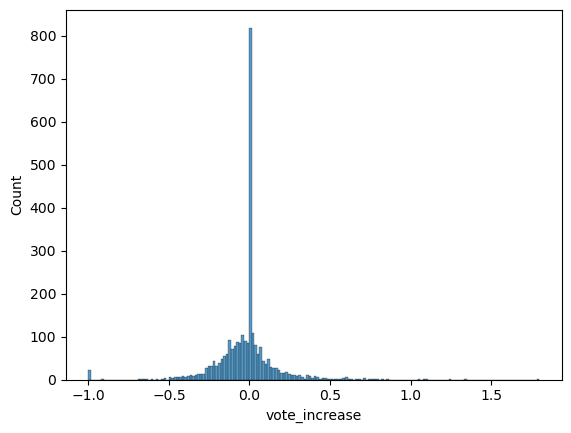

In [894]:
sns.histplot(df_insight["vote_increase"])

### แสดงจำนวน Word

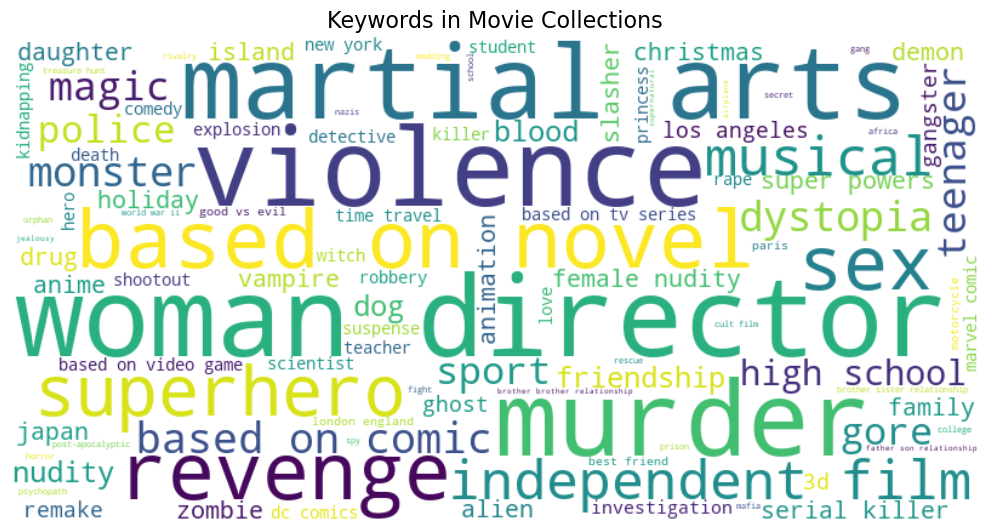

In [895]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
df_insight_pre = df_insight
# Filter to get one movie per collection
one_movie_per_collection = df_insight_pre.groupby('collection_name').first().reset_index()

# Extract all keywords from the filtered dataframe
all_keywords = []
for keywords in one_movie_per_collection['keywords'].dropna():
    if isinstance(keywords, list):
        all_keywords.extend(keywords)

# Count keyword frequencies
keyword_counts = Counter(all_keywords)

# Remove common sequel-related keywords if they exist
for keyword in ['sequel', 'duringcreditsstinger', 'aftercreditsstinger']:
    if keyword in keyword_counts:
        del keyword_counts[keyword]

# Create the word cloud
plt.figure(figsize=(10, 6))
if keyword_counts:  # Check if we have keywords to display
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(keyword_counts)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Keywords in Movie Collections', fontsize=16)
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "No keywords available for visualization", 
             horizontalalignment='center', fontsize=14)
    
plt.show()


### แสดงจำนวน genre

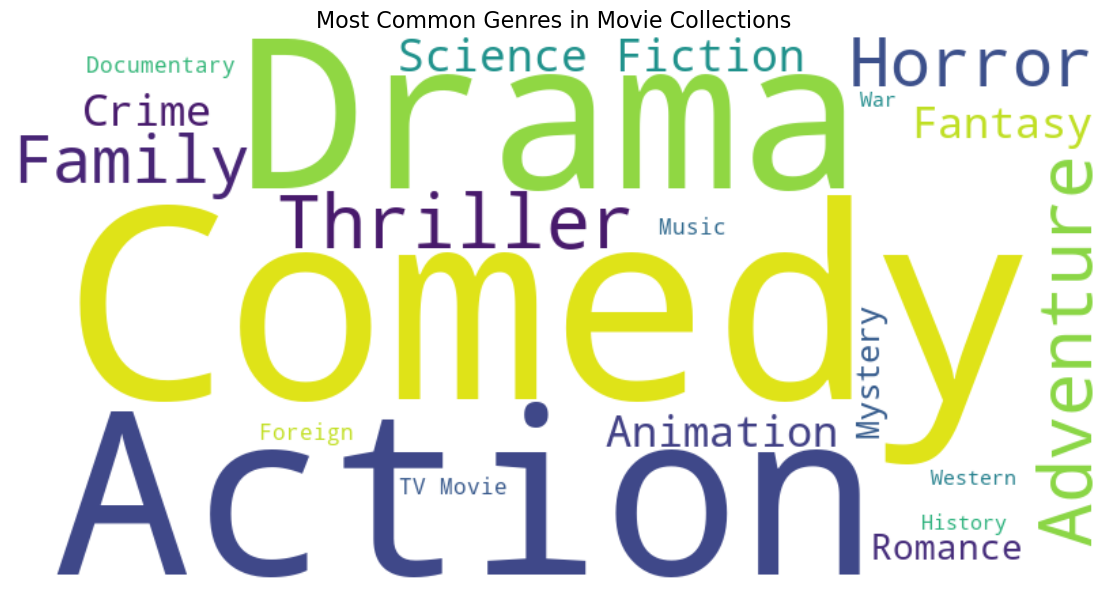

In [896]:
# Analyze most common genres in movie collections
all_genres = []
for genres in one_movie_per_collection['genres'].dropna():
    if isinstance(genres, list):
        all_genres.extend(genres)

# Count genre frequencies
genre_counts = Counter(all_genres)

# Create a word cloud for genres
plt.figure(figsize=(12, 6))
if genre_counts:
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=50,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(genre_counts)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Genres in Movie Collections', fontsize=16)
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "No genre data available for visualization", 
             horizontalalignment='center', fontsize=14)
plt.show()

## บันทึก

In [897]:
df_insight.to_csv("cleaned_6610401993.csv", encoding='utf8')
df_insight.to_pickle("cleaned_6610401993.pkl")

# Insight

### Import สิ่งที่จำเป็น

In [898]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
from sklearn.utils import shuffle
from scipy import stats
import kagglehub
import seaborn as sns

### ตั้ง seed เพื่อให้การทดลอง reproducible

In [899]:
np.random.seed(42)
random_state = 42

### ตั้งค่านัยสำคัญไว้ก่อนที่จะทดลอง

In [900]:
ALPHA = 0.05

### โหลดชุดข้อมูลเป้าหมาย

In [901]:
df_insight = pd.read_pickle("cleaned_6610401993.pkl")

In [902]:
df_insight.columns

Index(['adult', 'budget', 'genres', 'homepage', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'movie_id',
       'collection_name', 'movies_before', 'collection_count',
       'main_cast_gender', 'main_cast_character', 'main_cast_name',
       'movie_after', 'roi', 'keywords', 'vote_after',
       'next_main_cast_gender_same', 'next_main_cast_actor_name_same',
       'next_main_cast_same', 'vote_increase'],
      dtype='object')

### กรองข้อมูลให้เหลือเฉพาะที่เกี่ยวข้อง
- ลบข้อมูลหนังที่ไม่มีภาคต่อ (เราวิเคราะห์เฉพาะที่มีภาคต่อ)
- จำกัดสูงสุด 5 เรื่องต่อ collection (เพื่อไม่ให้เกิดการซ้ำซ้อนของ keyword ที่จะทำให้การวิเคราะห์ผิดพลาด)
- ลบค่าสุดโต่ง
- ลบ row ที่มีค่าที่สนใจได้แก่ "vote_increase", "vote_after" (เราไม่สามารถวิเคราะห์อันที่ไม่มีได้)
- ลบ keyword ที่แม้พบบ่อยแต่ก็ไม่มีความหมาย ได้แก่ 'sequel', 'duringcreditsstinger', 'aftercreditsstinger'

In [903]:
df_insight = df_insight[df_insight["movie_after"]!=0.0]
df_insight = df_insight.groupby("collection_name").head(5)
df_insight = df_insight.replace([np.inf, -np.inf], np.nan)
df_insight = df_insight.dropna(subset=["vote_increase", "vote_after"])
df_insight.shape

(2459, 38)

In [904]:
all_keywords = []
for keywords in df_insight['keywords'].dropna():
    all_keywords.extend(keywords)
unique_keywords = list(set(all_keywords))

if 'sequel' in unique_keywords:
    unique_keywords.remove('sequel')
if 'duringcreditsstinger' in unique_keywords:
    unique_keywords.remove('duringcreditsstinger')
if 'aftercreditsstinger' in unique_keywords:
    unique_keywords.remove('aftercreditsstinger')

def keyword_to_onehot(keywords_list, unique_keywords):
    if isinstance(keywords_list, list):
        return {f"keyword_{keyword}": 1 if keyword in keywords_list else 0 for keyword in unique_keywords}
    else:
        return {f"keyword_{keyword}": 0 for keyword in unique_keywords}

keyword_dummies = df_insight['keywords'].apply(
    lambda x: keyword_to_onehot(x, unique_keywords)
)

keyword_df = pd.DataFrame(keyword_dummies.tolist(), index=df_insight.index)

df_insight = pd.concat([df_insight, keyword_df], axis=1)

### สกัดเฉพาะ Column ที่สนใจ

In [905]:
interested = df_insight.drop(["movie_id","vote_after","roi","genres","keywords"],axis=1)

### วิเคราะห์ความสัมพันธ์ระหว่างภาพยนตร์ที่มีตัวละครเหมือนกันกับที่ไม่เหมือนกัน

-0.018979878583000626


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


-0.0461138858560842


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


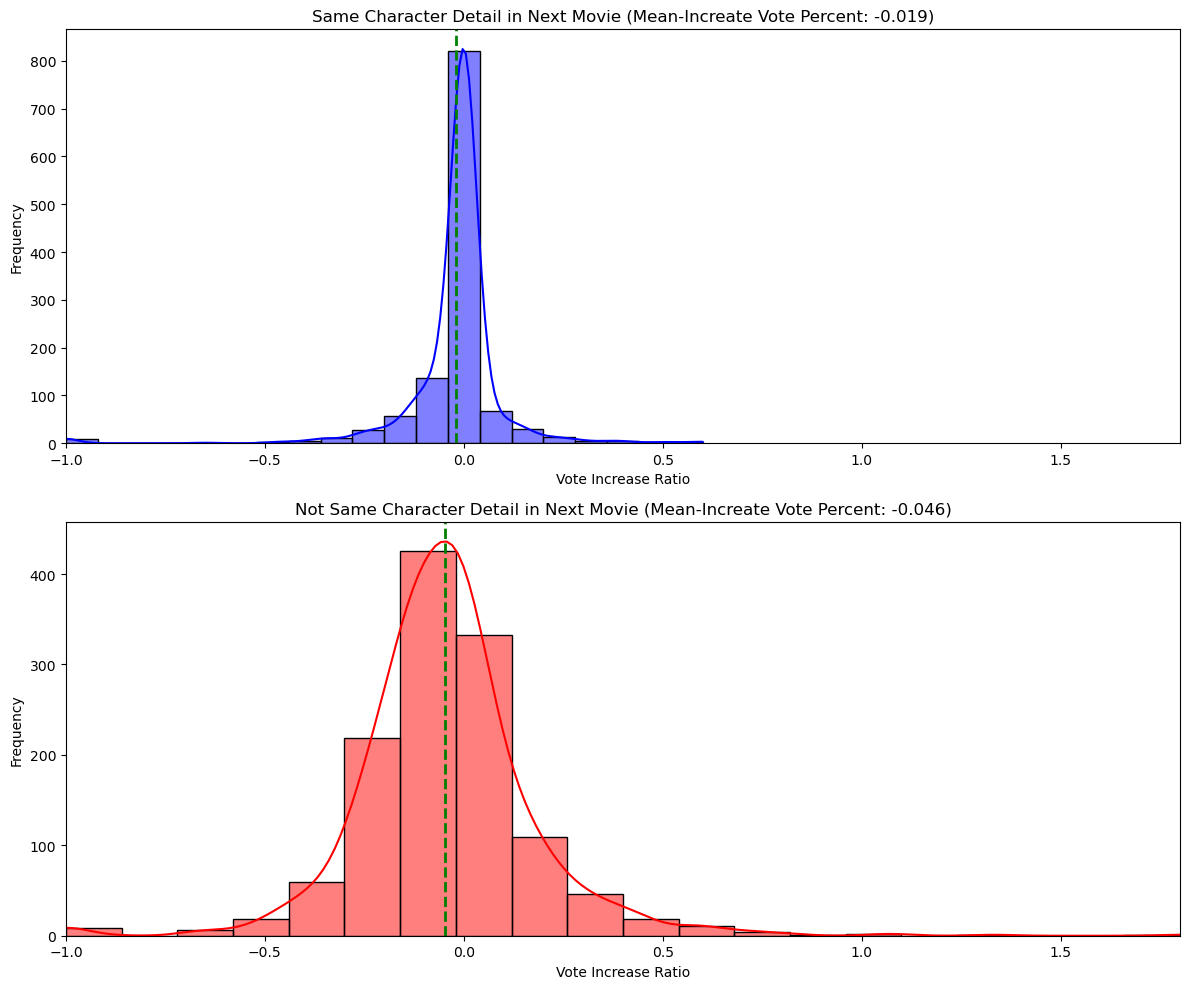

In [906]:
ptr = df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3]["vote_increase"]
print(ptr.mean())
# Find global min and max for consistent x-axis limits
min_val = df_insight['vote_increase'].min()
max_val = df_insight['vote_increase'].max()

fig, axes = plt.subplots(2, 1, figsize=(12,10))

sns.histplot(data=ptr, kde=True, ax=axes[0], bins=20, color='blue')
axes[0].axvline(ptr.mean(), color='green', linestyle='--', linewidth=2)
axes[0].set_title(f'Same Character Detail in Next Movie (Mean-Increate Vote Percent: {ptr.mean():.3f})')
axes[0].set_xlabel('Vote Increase Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(min_val, max_val)


ptr = df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3]["vote_increase"]
print(ptr.mean())
sns.histplot(data=ptr, kde=True, ax=axes[1], bins=20, color='red')
axes[1].axvline(ptr.mean(), color='green', linestyle='--', linewidth=2)
axes[1].set_title(f'Not Same Character Detail in Next Movie (Mean-Increate Vote Percent: {ptr.mean():.3f})')
axes[1].set_xlabel('Vote Increase Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(min_val, max_val)

plt.tight_layout()
plt.show()

In [907]:
# Create a table to show the differences between same and different character details
comparison_data = {
    'Category': ['Same Character Details', 'Different Character Details'],
    'Mean Vote Increase': [
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3]["vote_increase"].mean(),
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3]["vote_increase"].mean()
    ],
    'Sample Size': [
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)==3].shape[0],
        df_insight[df_insight[["next_main_cast_gender_same","next_main_cast_actor_name_same","next_main_cast_same"]].sum(axis=1)!=3].shape[0]
    ]
}

# Convert to DataFrame for better display
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

,Category,Mean Vote Increase,Sample Size
0,Same Character Details,-0.018980,1194
1,Different Character Details,-0.046114,1265


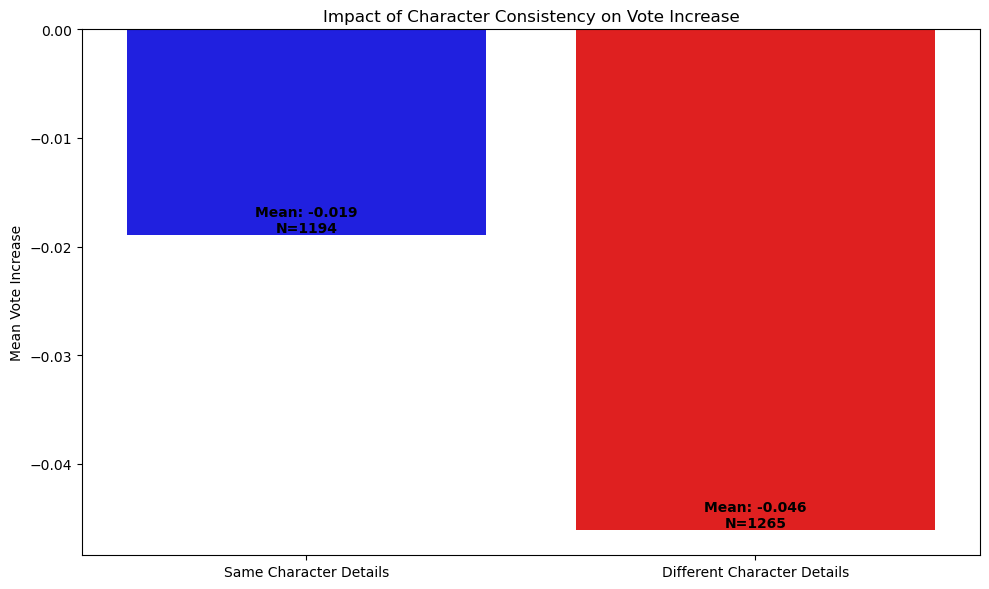

In [908]:

# Create a bar chart to visualize the difference
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Mean Vote Increase', data=comparison_df, palette=['blue', 'red'])
plt.title('Impact of Character Consistency on Vote Increase')
plt.ylabel('Mean Vote Increase')
plt.xlabel('')

# Add text annotations on bars
for i, row in enumerate(comparison_df.itertuples()):
    ax.text(i, row._2, f'Mean: {row._2:.3f}\nN={row._3}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### วิเคราะห์ให้ลึกไปอีก ว่าการเปลี่ยนแปลงตัวละครแต่ละแบบส่งผลหรือไม่

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

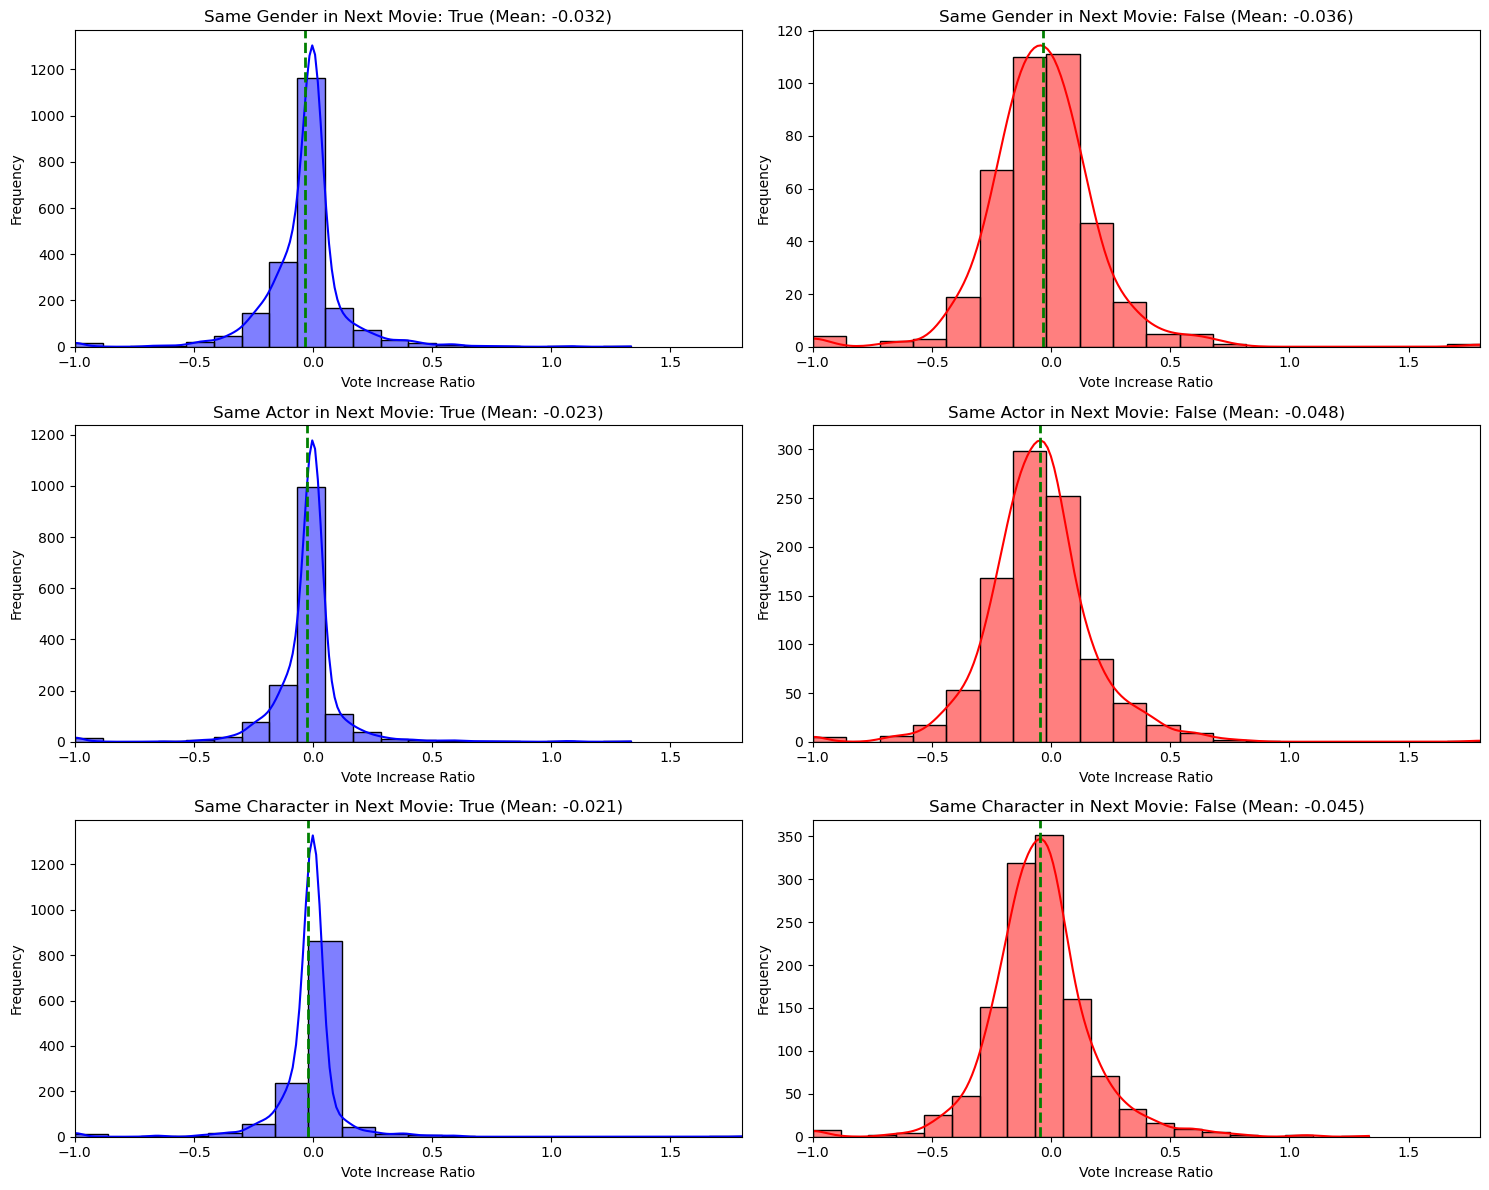

In [909]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Find global min and max for consistent x-axis limits
min_val = df_insight['vote_increase'].min()
max_val = df_insight['vote_increase'].max()

# next_main_cast_gender_same
# True
true_gender_data = df_insight[df_insight['next_main_cast_gender_same']==True]['vote_increase']
true_gender_mean = true_gender_data.mean()
sns.histplot(data=true_gender_data, kde=True, bins=20, ax=axes[0, 0], color='blue')
axes[0, 0].axvline(true_gender_mean, color='green', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'Same Gender in Next Movie: True (Mean: {true_gender_mean:.3f})')
axes[0, 0].set_xlabel('Vote Increase Ratio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(min_val, max_val)

# False
false_gender_data = df_insight[df_insight['next_main_cast_gender_same']==False]['vote_increase']
false_gender_mean = false_gender_data.mean()
sns.histplot(data=false_gender_data, kde=True, bins=20, ax=axes[0, 1], color='red')
axes[0, 1].axvline(false_gender_mean, color='green', linestyle='--', linewidth=2)
axes[0, 1].set_title(f'Same Gender in Next Movie: False (Mean: {false_gender_mean:.3f})')
axes[0, 1].set_xlabel('Vote Increase Ratio')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(min_val, max_val)

# next_main_cast_actor_name_same
# True
true_actor_data = df_insight[df_insight['next_main_cast_actor_name_same']==True]['vote_increase']
true_actor_mean = true_actor_data.mean()
sns.histplot(data=true_actor_data, kde=True, bins=20, ax=axes[1, 0], color='blue')
axes[1, 0].axvline(true_actor_mean, color='green', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Same Actor in Next Movie: True (Mean: {true_actor_mean:.3f})')
axes[1, 0].set_xlabel('Vote Increase Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(min_val, max_val)

# False
false_actor_data = df_insight[df_insight['next_main_cast_actor_name_same']==False]['vote_increase']
false_actor_mean = false_actor_data.mean()
sns.histplot(data=false_actor_data, kde=True, bins=20, ax=axes[1, 1], color='red')
axes[1, 1].axvline(false_actor_mean, color='green', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Same Actor in Next Movie: False (Mean: {false_actor_mean:.3f})')
axes[1, 1].set_xlabel('Vote Increase Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(min_val, max_val)

# next_main_cast_same
# True
true_character_data = df_insight[df_insight['next_main_cast_same']==True]['vote_increase']
true_character_mean = true_character_data.mean()
sns.histplot(data=true_character_data, kde=True, bins=20, ax=axes[2, 0], color='blue')
axes[2, 0].axvline(true_character_mean, color='green', linestyle='--', linewidth=2)
axes[2, 0].set_title(f'Same Character in Next Movie: True (Mean: {true_character_mean:.3f})')
axes[2, 0].set_xlabel('Vote Increase Ratio')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_xlim(min_val, max_val)

# False
false_character_data = df_insight[df_insight['next_main_cast_same']==False]['vote_increase']
false_character_mean = false_character_data.mean()
sns.histplot(data=false_character_data, kde=True, bins=20, ax=axes[2, 1], color='red')
axes[2, 1].axvline(false_character_mean, color='green', linestyle='--', linewidth=2)
axes[2, 1].set_title(f'Same Character in Next Movie: False (Mean: {false_character_mean:.3f})')
axes[2, 1].set_xlabel('Vote Increase Ratio')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_xlim(min_val, max_val)

plt.tight_layout()
plt.show()



### สร้างตารางสรุปแต่ละประเภท

In [910]:
plot_data = {
    'Comparison': ['Gender', 'Gender', 'Actor', 'Actor', 'Character', 'Character'],
    'Same in Next Movie': ['True', 'False', 'True', 'False', 'True', 'False'],
    'Mean Vote Increase': [
        f'{true_gender_mean:.3f}', 
        f'{false_gender_mean:.3f}',
        f'{true_actor_mean:.3f}', 
        f'{false_actor_mean:.3f}',
        f'{true_character_mean:.3f}', 
        f'{false_character_mean:.3f}'
    ],
    'Sample Size': [
        f'{len(true_gender_data)}',
        f'{len(false_gender_data)}',
        f'{len(true_actor_data)}',
        f'{len(false_actor_data)}',
        f'{len(true_character_data)}',
        f'{len(false_character_data)}'
    ]
}

summary_df = pd.DataFrame(plot_data)
summary_df['Same in Next Movie'] = summary_df['Same in Next Movie'].map({'True': True, 'False': False})
summary_df['Sample Size'] = summary_df['Sample Size'].astype(int)
summary_df = summary_df.set_index(['Comparison', 'Same in Next Movie'])
summary_df = summary_df.sort_index()
summary_df

Mean Vote Increase  Sample Size
Comparison Same in Next Movie                                
Actor      False                          -0.048          954
           True                           -0.023         1505
Character  False                          -0.045         1208
           True                           -0.021         1251
Gender     False                          -0.036          392
           True                           -0.032         2067

### สร้างชุดที่เก็บ keyword และจำนวนของที่ Vote Increase เพิ่มขึ้น และ Vote Increase ลดลง

In [911]:
# Perform basic analysis to see if keywords affect vote increase
print("\nKeyword Analysis for Vote Increase:")

# Split data into two groups
vote_increase_df = interested[interested["vote_increase"] >= 0]
vote_decrease_df = interested[interested["vote_increase"] < 0]

print(f"Number of movies with increased votes: {len(vote_increase_df)}")
print(f"Number of movies with decreased votes: {len(vote_decrease_df)}")

# Get keyword columns
keyword_columns = [col for col in interested.columns if col.startswith('keyword_')]

# Calculate keyword frequencies for each group
increase_keywords = {}
decrease_keywords = {}

for col in keyword_columns:
    keyword = col[8:]  # Remove 'keyword_' prefix
    
    # Count occurrences in increased votes group
    increase_count = vote_increase_df[col].sum()
    if increase_count > 0:
        increase_keywords[keyword] = increase_count
    
    # Count occurrences in decreased votes group
    decrease_count = vote_decrease_df[col].sum()
    if decrease_count > 0:
        decrease_keywords[keyword] = decrease_count

# Create DataFrames for visualization
increase_df = pd.DataFrame(list(increase_keywords.items()), columns=['Keyword', 'Count'])
increase_df = increase_df.sort_values('Count', ascending=False)

decrease_df = pd.DataFrame(list(decrease_keywords.items()), columns=['Keyword', 'Count'])
decrease_df = decrease_df.sort_values('Count', ascending=False)


Keyword Analysis for Vote Increase:
Number of movies with increased votes: 1357
Number of movies with decreased votes: 1102


### แสดง Top 10 ของ หนังที่มี vote เพิ่มในภาคถัดไป และลดในภาคภัดไป

In [912]:
# Display top keywords for each group
print("\nTop 10 keywords in movies with increased votes:")
print(increase_df.head(10))

print("\nTop 10 keywords in movies with decreased votes:")
print(decrease_df.head(10))


Top 10 keywords in movies with increased votes:
             Keyword  Count
2543        violence     36
3573  woman director     36
2296  based on novel     35
2858           anime     33
2175          murder     31
31               sex     31
1481         vampire     30
2342           magic     30
194     martial arts     29
497       friendship     28

Top 10 keywords in movies with decreased votes:
               Keyword  Count
2273            murder     54
2609          violence     43
205            revenge     38
206       martial arts     37
2382    based on novel     35
288           dystopia     33
3586    woman director     32
208              blood     31
1259           monster     30
2748  independent film     29


### สร้างตารางเพื่อเปลี่ยบเทียบความถี่ keyword แต่ละคำ ว่าอยู่ในที่เพิ่มขึ้นและลดลงในอัตราเท่าไร

In [913]:
# Compare relative frequencies of top keywords between groups
top_keywords = pd.concat([
    increase_df.head(15)['Keyword'], 
    decrease_df.head(15)['Keyword']
]).unique()

comparison_data = []
for keyword in top_keywords:
    keyword_col = f'keyword_{keyword}'
    if keyword_col in interested.columns:
        # Calculate percentages
        increase_pct = vote_increase_df[keyword_col].mean() * 100
        decrease_pct = vote_decrease_df[keyword_col].mean() * 100
        
        comparison_data.append({
            'Keyword': keyword,
            'Increased Votes (%)': increase_pct,
            'Decreased Votes (%)': decrease_pct,
            'Difference': increase_pct - decrease_pct
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Difference', ascending=False)

print("\nComparison of keyword frequencies between groups:")
print(comparison_df)


Comparison of keyword frequencies between groups:
             Keyword  Increased Votes (%)  Decreased Votes (%)  Difference
3              anime             2.431835             1.361162    1.070673
6            vampire             2.210759             1.542650    0.668109
9         friendship             2.063375             1.542650    0.520725
10         superhero             2.063375             1.633394    0.429981
7              magic             2.210759             2.087114    0.123645
5                sex             2.284451             2.268603    0.015848
12     female nudity             1.842299             1.905626   -0.063327
11             sport             1.915991             1.996370   -0.080379
13           musical             1.842299             2.087114   -0.244815
1     woman director             2.652911             2.903811   -0.250900
20            nudity             1.694915             2.268603   -0.573687
2     based on novel             2.579219        

### สร้าง WordCloud เพื่อเปลี่ยบเทียบความถี่ keyword แต่ละคำ ว่าอยู่ในที่เพิ่มขึ้นและลดลงในอัตราเท่าไร

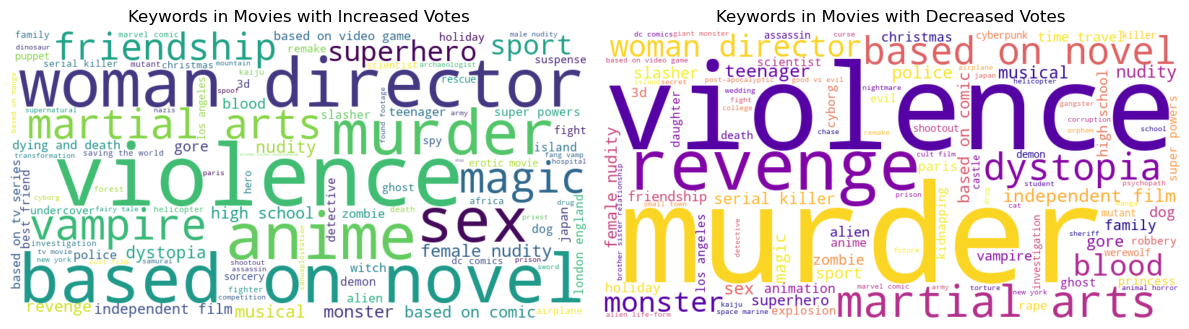

In [914]:
from wordcloud import WordCloud

plt.figure(figsize=(12, 5))

# Word cloud for increased votes
plt.subplot(1, 2, 1)
wordcloud_increase = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='viridis').generate_from_frequencies(increase_keywords)
plt.imshow(wordcloud_increase, interpolation='bilinear')
plt.title('Keywords in Movies with Increased Votes')
plt.axis('off')

# Word cloud for decreased votes
plt.subplot(1, 2, 2)
wordcloud_decrease = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='plasma').generate_from_frequencies(decrease_keywords)
plt.imshow(wordcloud_decrease, interpolation='bilinear')
plt.title('Keywords in Movies with Decreased Votes')
plt.axis('off')

plt.tight_layout()
plt.show()


### เปรียบเทียบ keyword ว่ามีผลต่อ Vote Increase ต่างกันเพียงใด

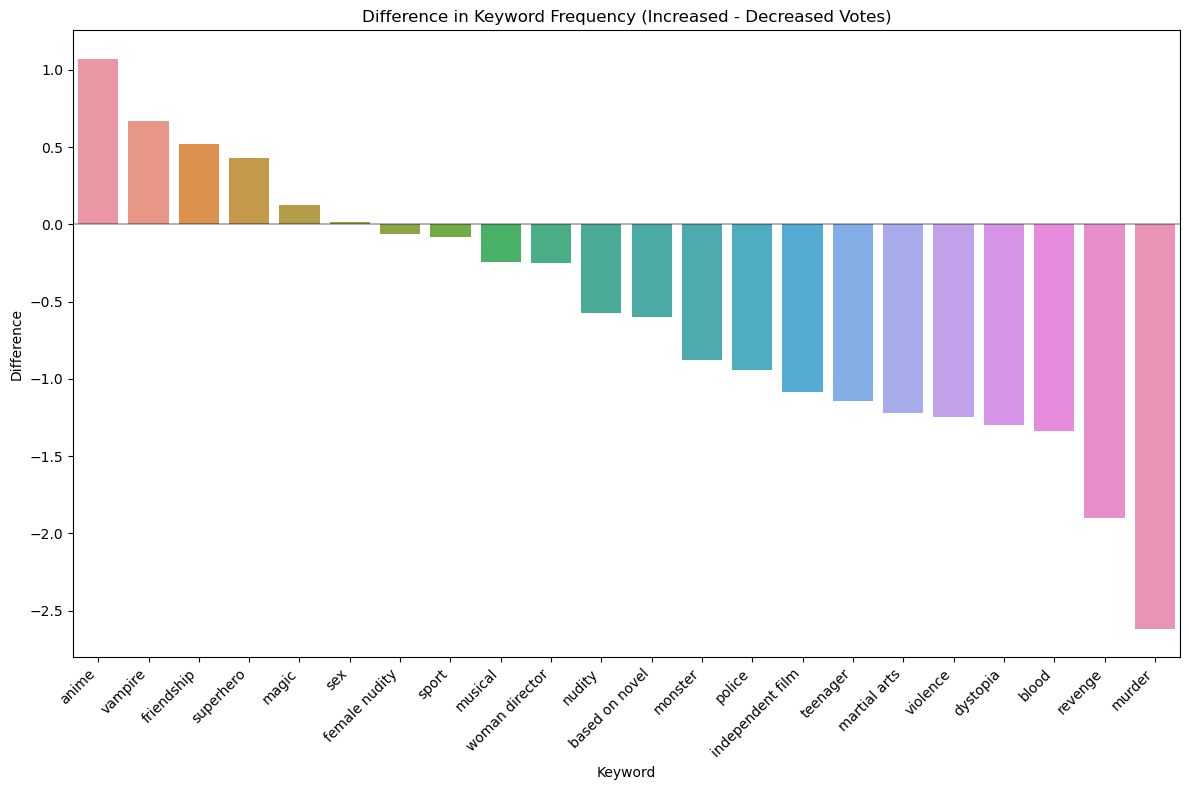

In [915]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Keyword', y='Difference', data=comparison_df)
plt.title('Difference in Keyword Frequency (Increased - Decreased Votes)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

### สร้าง DataFrame เพื่อเก็บ "หนัง" ที่มี word_increase เพิ่ม และ word_increase ลด

In [916]:
decreased_votes_df = interested[interested["vote_increase"] < 0]
increased_votes_df = interested[interested["vote_increase"] >= 0]


### หาว่ามี keyword ใดบ้าง โดยดูจากชื่อ column

In [917]:
# Create X (features) and y (target)
keyword_columns = [col for col in interested.columns if col.startswith('keyword_')]

## หาว่า keyword ใดส่งผลให้ vote_increase ลด มากที่สุด

### กรอง Keyword ที่มีจำนวนน้อยเกินไปออก (<10) และสร้าง y ซึ่งคือ Feature ที่สนใจว่า vote_increase จะลดหรือไม่

In [918]:
# Filter out rare keywords (occurring less than 5 times in total)
keyword_counts = interested[keyword_columns].sum()
frequent_keywords = keyword_counts[keyword_counts >= 10].index.tolist()

X = interested[frequent_keywords]
y = (interested["vote_increase"] < 0).astype(int) 

### ทำการค้นหาว่า Keyword ใดส่งผลต่อการลดลงของ vote_increase
- ทำการใช้ chi2 test ดูความ predictive ของ keyword นั้นส่งผลกับ vote_increase ไหม
- โดยทำการทดสอบ permutation_test กับทุก keyword ที่ทำให้ค่าเฉลี่ย vote_increase น้อยลง ว่าทำให้น้อยลงจริงๆไหม โดยตั้งสมมุติฐานดังนี้
- H0 : keyword ทำให้มี vote_increae น้อยลงเป็นเรื่องบังเอิญ
- H1 : keyword ทำให้มี vote_increae น้อยลงเป็นเรื่องไม่บังเอิญ
- ถ้ายอมรับ H1 เป็นจริง จะบันทึก keyword นั้น และค่า statistic ของ chi2 ไว้คู่กัน
- เรียงลำดับ keyword ที่ยอมรับ H1 จากค่า chi2 หรือความ predictive

In [919]:
chi2_values, p_values = chi2(X, y)

permutation_results = {}

n_permutations = 1000

for i, col in enumerate(frequent_keywords):
    keyword = col[8:] 

    if decreased_votes_df[col].sum() > 0:
        decreased_pct = decreased_votes_df[col].sum() / len(decreased_votes_df)
        increased_pct = increased_votes_df[col].sum() / len(increased_votes_df) if len(increased_votes_df) > 0 else 0
        observed_diff = decreased_pct - increased_pct

        if observed_diff <= 0:
            continue

        permutation_diffs = []
        combined_data = interested[col].values
        combined_labels = y.values
        
        for _ in range(n_permutations):
            shuffled_labels = shuffle(combined_labels)
            
            perm_decreased = combined_data[shuffled_labels == 1]
            perm_increased = combined_data[shuffled_labels == 0]
            
            perm_decreased_pct = np.mean(perm_decreased) if len(perm_decreased) > 0 else 0
            perm_increased_pct = np.mean(perm_increased) if len(perm_increased) > 0 else 0
            
            permutation_diffs.append(perm_decreased_pct - perm_increased_pct)
        
        # proportion of permutations with diff >= observed)
        p_value = np.mean([diff >= observed_diff for diff in permutation_diffs])
        
        if p_value < ALPHA: 
            ratio = decreased_pct / increased_pct if increased_pct > 0 else float('inf')
            permutation_results[keyword] = {
                'chi2': chi2_values[i],
                'diff' : observed_diff,
                'p_value': p_value,
                'ratio': ratio,
                'decreased_pct': decreased_pct * 100,
                'increased_pct': increased_pct * 100,
                'count': keyword_counts[col]
            }

### สร้าง word_cloud โดยใช้ความ predictive เป็น weight 
- หรือก็คือ keyword ที่มีความสามารถในการ predictive การลด vote increase จะมีน้ำหนักมาก

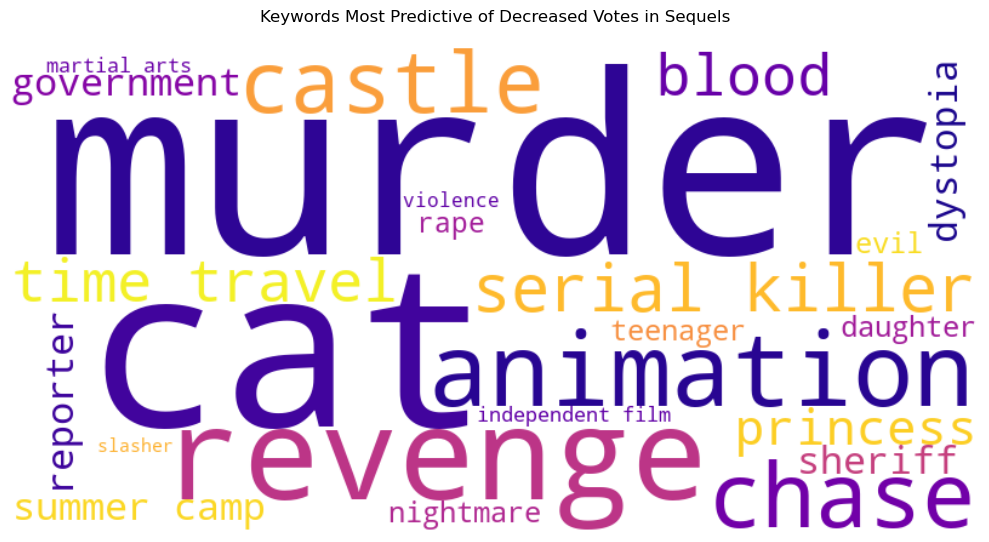

In [920]:
# sort by chi2 value
sorted_keywords = {k: v for k, v in sorted(permutation_results.items(), 
                                          key=lambda item: item[1]['chi2'], 
                                          reverse=True)}

wordcloud_dict = {k: v['chi2'] for k, v in sorted_keywords.items()}

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                        max_words=100, colormap='plasma').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords Most Predictive of Decreased Votes in Sequels\n')
plt.tight_layout()
plt.show()


### 10 คำสำคัญที่ทำนายการลดลงของคะแนนโหวตในภาคต่อได้มากที่สุด:

In [921]:
for i, (keyword, stats_dict) in enumerate(list(sorted_keywords.items())[:10]):
    print(f"{i+1}. {keyword}: {stats_dict['decreased_pct']:.2f}% ในกลุ่มที่คะแนนลดลง vs "
            f"{stats_dict['increased_pct']:.2f}% ในกลุ่มที่คะแนนเพิ่มขึ้น "
            f"(อัตราส่วน: {stats_dict['ratio']:.2f}, ค่า p-value: {stats_dict['p_value']:.4f}, "
            f"จำนวนที่พบทั้งหมด: {stats_dict['count']})")

1. murder: 4.90% ในกลุ่มที่คะแนนลดลง vs 2.28% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.15, ค่า p-value: 0.0000, จำนวนที่พบทั้งหมด: 85)
2. cat: 0.91% ในกลุ่มที่คะแนนลดลง vs 0.07% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 12.31, ค่า p-value: 0.0020, จำนวนที่พบทั้งหมด: 11)
3. revenge: 3.45% ในกลุ่มที่คะแนนลดลง vs 1.55% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.23, ค่า p-value: 0.0010, จำนวนที่พบทั้งหมด: 59)
4. animation: 1.45% ในกลุ่มที่คะแนนลดลง vs 0.37% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 3.94, ค่า p-value: 0.0030, จำนวนที่พบทั้งหมด: 21)
5. chase: 1.00% ในกลุ่มที่คะแนนลดลง vs 0.22% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 4.52, ค่า p-value: 0.0180, จำนวนที่พบทั้งหมด: 14)
6. castle: 1.09% ในกลุ่มที่คะแนนลดลง vs 0.29% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 3.69, ค่า p-value: 0.0120, จำนวนที่พบทั้งหมด: 16)
7. serial killer: 2.00% ในกลุ่มที่คะแนนลดลง vs 0.88% ในกลุ่มที่คะแนนเพิ่มขึ้น (อัตราส่วน: 2.26, ค่า p-value: 0.0110, จำนวนที่พบทั้งหมด: 34)
8. time travel: 1.54% ในกลุ่มที่คะแนนลดลง vs 0.59% ในกลุ่มที่

### แบ่งชุดข้อมูลที่มี keyword นั้นกับที่ไม่มี

In [922]:
list(sorted_keywords.keys())
# find the row that contain one of the keyword
# Let's find examples of movies that contain the top predictive keywords
top_keywords = list(sorted_keywords.keys())[:15]  # Get top 15 keywords
nt = []
for k in top_keywords:
    nt.append("keyword_"+k)

def contains_top_keyword(row):
    return sum(row[nt]) != 0

contain_keyword = interested[interested.apply(lambda x: contains_top_keyword(x), axis=1)]
not_contain_keyword = interested[interested.apply(lambda x: not contains_top_keyword(x), axis=1)]


In [923]:
mean_with_keywords = contain_keyword["vote_increase"].mean()
mean_without_keywords = not_contain_keyword["vote_increase"].mean()
difference = mean_with_keywords - mean_without_keywords
pct = mean_with_keywords/mean_without_keywords*100

In [924]:
print(f"{top_keywords}")
print(f"หนังที่มี keyword เหล่านี้ในภาคต่อไปมักจะมีคะแนนต่ำกว่าหนังที่ไม่มี keyword เหล่านี้ {pct:.2f}%")

['murder', 'cat', 'revenge', 'animation', 'chase', 'castle', 'serial killer', 'time travel', 'blood', 'princess', 'government', 'summer camp', 'reporter', 'sheriff', 'dystopia']
หนังที่มี keyword เหล่านี้ในภาคต่อไปมักจะมีคะแนนต่ำกว่าหนังที่ไม่มี keyword เหล่านี้ 234.15%


### Visualize Impact ของการมี keyword เหล่่านี้ หรือการไม่มี

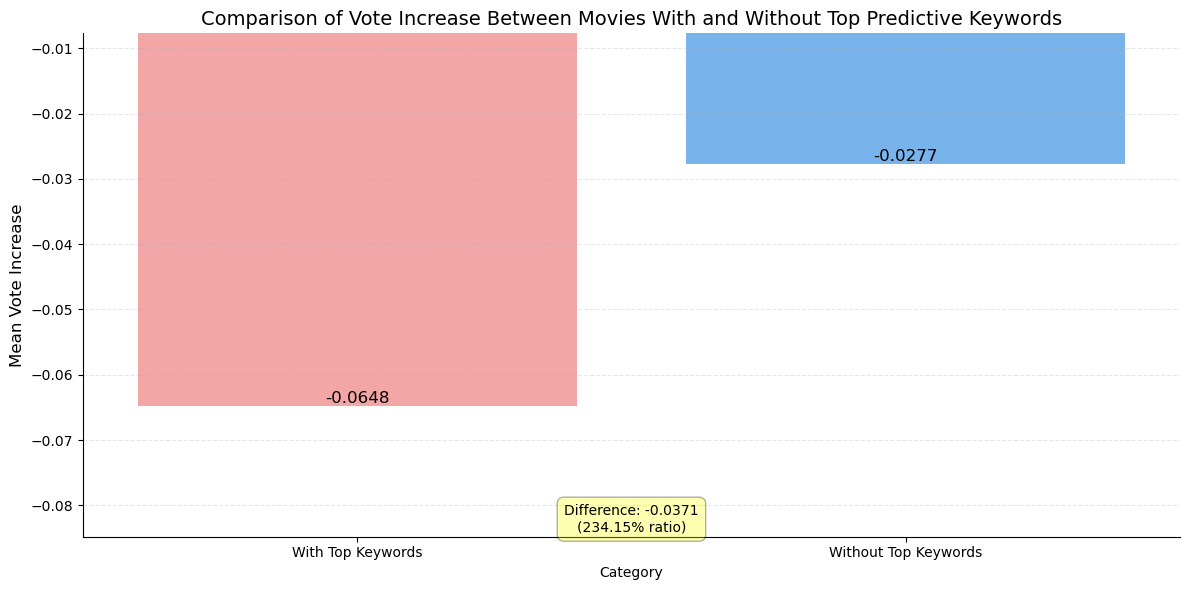

In [925]:
# Prepare data for seaborn
comparison_data = pd.DataFrame({
    'Category': ['With Top Keywords', 'Without Top Keywords'],
    'Mean Vote Increase': [mean_with_keywords, mean_without_keywords]
})

# Create the bar chart with seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Category', y='Mean Vote Increase', data=comparison_data, palette=['#ff9999', '#66b3ff'])

# Add data labels on top of the bars
for i, v in enumerate(comparison_data['Mean Vote Increase']):
    ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Add title and labels
plt.title('Comparison of Vote Increase Between Movies With and Without Top Predictive Keywords', fontsize=14)
plt.ylabel('Mean Vote Increase', fontsize=12)
plt.ylim(min(comparison_data['Mean Vote Increase']) - 0.02, max(comparison_data['Mean Vote Increase']) + 0.02)

# Add annotation about the difference
plt.annotate(f'Difference: {difference:.4f}\n({pct:.2f}% ratio)',
             xy=(0.5, min(comparison_data['Mean Vote Increase']) - 0.01),
             xytext=(0.5, min(comparison_data['Mean Vote Increase']) - 0.015),
             ha='center', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

# Add styling
sns.despine(left=False, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### หา CI ที่ 95% ของความแตกต่างระหว่างการมีกับไม่มี keyword นั้น

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\3975579009.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


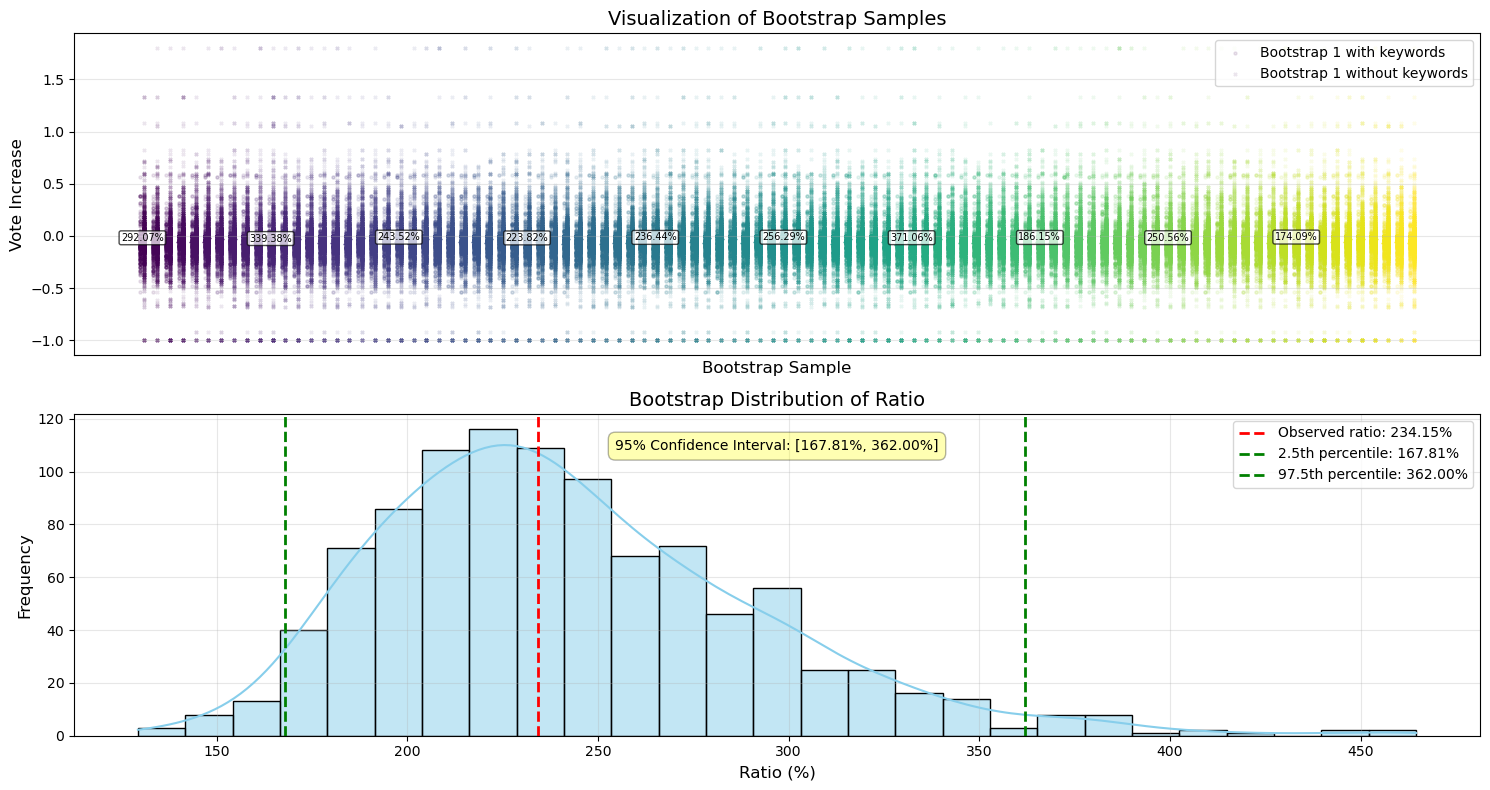

In [926]:
# Calculate confidence interval for the ratio (pct) using bootstrap sampling
n_bootstrap = 1000
bootstrap_ratios = []

np.random.seed(42)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
sample_to_show = 100
colors = plt.cm.viridis(np.linspace(0, 1, sample_to_show))

for i in range(n_bootstrap):
    sample_with = contain_keyword.sample(len(contain_keyword), replace=True)["vote_increase"]
    sample_without = not_contain_keyword.sample(len(not_contain_keyword), replace=True)["vote_increase"]

    mean_with_sample = sample_with.mean()
    mean_without_sample = sample_without.mean()

    ratio = mean_with_sample / mean_without_sample * 100
    bootstrap_ratios.append(ratio)

    if i < sample_to_show:
        plt.scatter(np.ones(len(sample_with)) * (i+1), sample_with, 
                   alpha=0.1, color=colors[i], s=5, label=f'Bootstrap {i+1} with keywords' if i == 0 else "")
        plt.scatter(np.ones(len(sample_without)) * (i+1.3), sample_without, 
                   alpha=0.1, color=colors[i], marker='x', s=5, label=f'Bootstrap {i+1} without keywords' if i == 0 else "")

        plt.hlines(mean_with_sample, i+0.8, i+1.2, colors=colors[i], linewidth=1)
        plt.hlines(mean_without_sample, i+1.1, i+1.5, colors=colors[i], linewidth=1, linestyle='--')

        if i % 10 == 0:
            plt.text(i+1.15, (mean_with_sample + mean_without_sample)/2, 
                    f'{ratio:.2f}%', fontsize=7, ha='center', 
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

plt.title('Visualization of Bootstrap Samples', fontsize=14)
plt.ylabel('Vote Increase', fontsize=12)
plt.xlabel('Bootstrap Sample', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks([])
plt.legend()

plt.subplot(2, 1, 2)
bootstrap_ratios = np.array(bootstrap_ratios)

lower_ci = np.percentile(bootstrap_ratios, 2.5)
upper_ci = np.percentile(bootstrap_ratios, 97.5)

sns.histplot(bootstrap_ratios, kde=True, color='skyblue')
plt.axvline(pct, color='red', linestyle='dashed', linewidth=2, label=f'Observed ratio: {pct:.2f}%')
plt.axvline(lower_ci, color='green', linestyle='dashed', linewidth=2, label=f'2.5th percentile: {lower_ci:.2f}%')
plt.axvline(upper_ci, color='green', linestyle='dashed', linewidth=2, label=f'97.5th percentile: {upper_ci:.2f}%')

plt.title('Bootstrap Distribution of Ratio', fontsize=14)
plt.xlabel('Ratio (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

plt.annotate(f'95% Confidence Interval: [{lower_ci:.2f}%, {upper_ci:.2f}%]',
             xy=(0.5, 0.9), xycoords='axes fraction',
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

## ทดสอบสมมุติฐาน 
 - ภาพยนตร์ที่มี keyword เหล่านั้น มีแนวโน้มที่จะมีคะแนนเพิ่มขึ้นในภาคถัดไป น้อยกว่า ภาพยนตร์ที่ไม่มี keyword เหล่านั้น จริงไหม

In [927]:
# Perform bootstrap test to see if movies with these keywords have significantly lower vote increases
n_bootstrap = 1000
observed_diff = contain_keyword["vote_increase"].mean() - not_contain_keyword["vote_increase"].mean()
print(observed_diff)
# Bootstrap sampling
bootstrap_diffs = []
for _ in range(n_bootstrap):
    # Resample with replacement from each group
    #sample_with = np.random.choice(interested["vote_increase"], size=len(contain_keyword))
    sample_with = interested.sample(len(contain_keyword))["vote_increase"]
    sample_without = interested.drop(contain_keyword.index)["vote_increase"]
    
    # Calculate the difference in means for this bootstrap sample
    bootstrap_diff = np.mean(sample_with) - np.mean(sample_without)
    bootstrap_diffs.append(bootstrap_diff)

# Calculate p-value (proportion of bootstrap samples with difference >= observed_diff)
# For a one-sided test (less than), we count how many bootstrap differences are <= observed_diff
p_value = np.mean(np.array(bootstrap_diffs) <= observed_diff)


print(f"ผลการทดสอบ Bootstrap (n={n_bootstrap}):")
print(f"ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: {observed_diff:.4f}")
print(f"ที่ CI 95% สำหรับความแตกต่าง: [{np.percentile(bootstrap_diffs, 2.5):.4f}, {np.percentile(bootstrap_diffs, 97.5):.4f}]")
print(f"ค่า p-value (การทดสอบทางเดียว): {p_value:.6f}")

if p_value < ALPHA:
    print(f"ผลลัพธ์มีนัยสำคัญทางสถิติ (p < {ALPHA}).")
    print(f"ภาพยนตร์ที่มี keyword เหล่านี้มีการเพิ่มขึ้นของคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ")
    
    # Calculate the mean difference
    print(f"ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่มี keyword: {mean_with_keywords:.4f}")
    print(f"ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่ไม่มี keyword: {mean_without_keywords:.4f}")
    print(f"ความแตกต่าง: {pct:.4f}%")
else:
    print(f"ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= {ALPHA}).")

-0.03713769370120137
ผลการทดสอบ Bootstrap (n=1000):
ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: -0.0371
ที่ CI 95% สำหรับความแตกต่าง: [-0.0232, 0.0123]
ค่า p-value (การทดสอบทางเดียว): 0.000000
ผลลัพธ์มีนัยสำคัญทางสถิติ (p < 0.05).
ภาพยนตร์ที่มี keyword เหล่านี้มีการเพิ่มขึ้นของคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ
ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่มี keyword: -0.0648
ค่าเฉลี่ยการเพิ่มขึ้นของคะแนนโหวตที่ไม่มี keyword: -0.0277
ความแตกต่าง: 234.1542%


C:\Users\sunmodza\AppData\Local\Temp\ipykernel_64168\3782972546.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bootstrap_diffs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


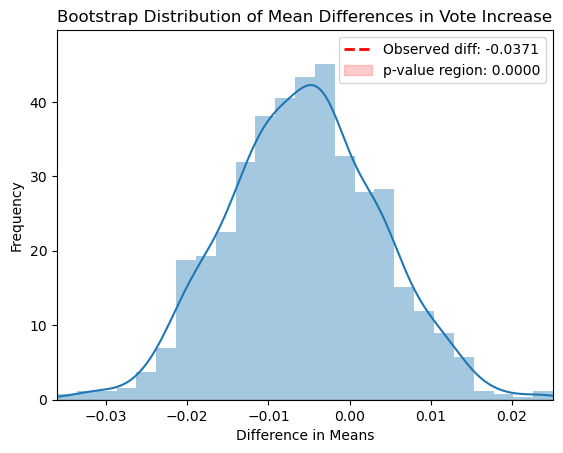

In [928]:
sns.distplot(bootstrap_diffs)
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2, label=f'Observed diff: {observed_diff:.4f}')
plt.title('Bootstrap Distribution of Mean Differences in Vote Increase')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')

# Highlight the p-value area on the plot
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)  # Add a horizontal line at y=0 for reference

# Calculate the 5% threshold for highlighting
threshold_index = int(0.05 * len(bootstrap_diffs))
sorted_diffs = np.sort(bootstrap_diffs)
threshold_value = sorted_diffs[threshold_index]

# Highlight the area representing the p-value
plt.fill_between(
    np.linspace(-9, observed_diff, 100),
    0, 
    plt.gca().get_ylim()[1],
    color='red', 
    alpha=0.2,
    label=f'p-value region: {p_value:.4f}'
)
plt.xlim(min(bootstrap_diffs),max(bootstrap_diffs))

plt.legend()

### ทดสอบว่าหากมี keyword นี้กับไม่มี keyword จะมีความแตกต่างของ vote average ในภาคปัจจุบันไหม

0.17550120605258712


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


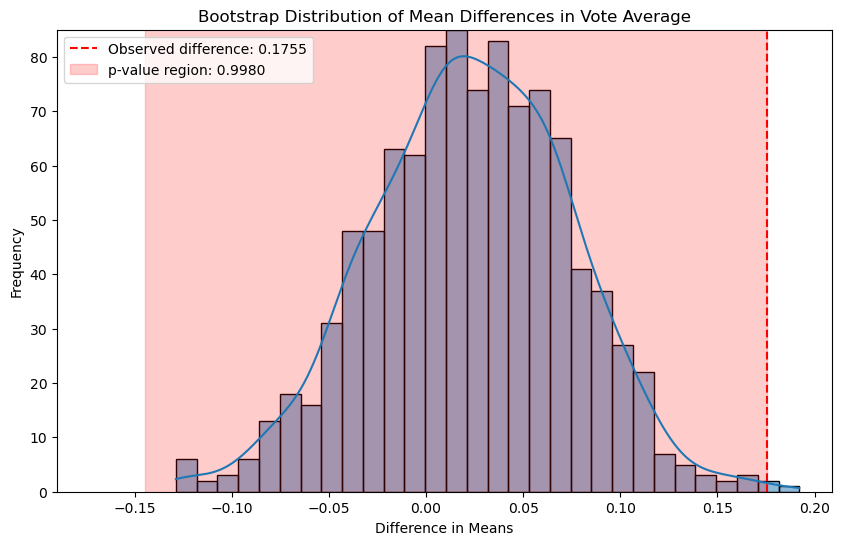

ผลการทดสอบ Bootstrap (n=1000):
ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: 0.1755
ที่ CI 95% สำหรับความแตกต่าง: [-0.0791, 0.1163]
ค่า p-value (การทดสอบทางเดียว): 0.998000
ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= 0.05).
ยอมรับ H0 ว่า
การที่ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตน้อยกว่าจากหนังที่ไม่มี keyword เหล่านี้ เป็นเรื่องบังเอิญ


In [929]:
n_bootstrap = 1000
observed_diff = contain_keyword["vote_average"].mean() - not_contain_keyword["vote_average"].mean()
print(observed_diff)
# Bootstrap sampling
bootstrap_diffs = []
for _ in range(n_bootstrap):
    sample_with = interested.sample(len(contain_keyword))["vote_average"]
    sample_without = interested.drop(contain_keyword.index)["vote_average"]

    bootstrap_diff = np.mean(sample_with) - np.mean(sample_without)
    bootstrap_diffs.append(bootstrap_diff)

p_value = np.mean(np.array(bootstrap_diffs) <= observed_diff)

# Calculate means for labeling
mean_with_keywords = contain_keyword["vote_average"].mean()
mean_without_keywords = not_contain_keyword["vote_average"].mean()
pct = (mean_with_keywords - mean_without_keywords) / mean_without_keywords * 100

# Visualize the bootstrap distribution
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_diffs, bins=30, kde=True)
plt.axvline(observed_diff, color='red', linestyle='--', 
            label=f'Observed difference: {observed_diff:.4f}')

# Highlight the area representing the p-value
plt.fill_between(
    np.linspace(plt.gca().get_xlim()[0], observed_diff, 100),
    0, 
    plt.gca().get_ylim()[1],
    color='red', 
    alpha=0.2,
    label=f'p-value region: {p_value:.4f}'
)
plt.ylim(0,85)
plt.xlim(-0.19)
plt.title('Bootstrap Distribution of Mean Differences in Vote Average')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.show()


print(f"ผลการทดสอบ Bootstrap (n={n_bootstrap}):")
print(f"ความแตกต่างของค่าเฉลี่ยที่สังเกตได้: {observed_diff:.4f}")
print(f"ที่ CI 95% สำหรับความแตกต่าง: [{np.percentile(bootstrap_diffs, 2.5):.4f}, {np.percentile(bootstrap_diffs, 97.5):.4f}]")
print(f"ค่า p-value (การทดสอบทางเดียว): {p_value:.6f}")

if p_value < ALPHA:
    print(f"ผลลัพธ์มีนัยสำคัญทางสถิติ (p < {ALPHA}).")
    print(f"ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตต่ำกว่าภาพยนตร์ที่ไม่มี keyword เหล่านี้อย่างมีนัยสำคัญ")

    print(f"ค่าเฉลี่ยคะแนนโหวตที่มี keyword: {mean_with_keywords:.4f}")
    print(f"ค่าเฉลี่ยงคะแนนโหวตที่ไม่มี keyword: {mean_without_keywords:.4f}")
    print(f"ความแตกต่าง: {pct:.4f}%")
else:
    print(f"ผลลัพธ์ไม่มีนัยสำคัญทางสถิติ (p >= {ALPHA}).")
    print(f"ยอมรับ H0 ว่า")
    print("การที่ภาพยนตร์ที่มีคำสำคัญเหล่านี้มีคะแนนโหวตน้อยกว่าจากหนังที่ไม่มี keyword เหล่านี้ เป็นเรื่องบังเอิญ")

